# **Python/Tensorflow implementation of Score-CAM explainability method**
Paper: 
Score-CAM: Score-Weighted Visual Explanations for Convolutional Neural Networks
https://arxiv.org/abs/1910.01279


In [6]:
import keras
import cv2
import tensorflow.keras as keras
import tensorflow as tf
from tensorflow.keras.models import Model
import matplotlib.pyplot as plt
import numpy as np
from keras.applications.vgg16 import VGG16
from keras.preprocessing.image import ImageDataGenerator
from keras.applications.vgg16 import preprocess_input
from keras.preprocessing.image import load_img
from numpy import asarray
from keras.preprocessing.image import img_to_array
from keras.applications.imagenet_utils import decode_predictions
from keras import backend as K
from skimage.transform import resize
from sklearn.preprocessing import normalize

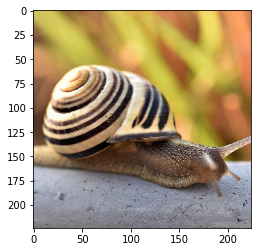

In [3]:
# preprocess phase, preparaing the image for going through vgg16 
image = load_img('snail.jpg', target_size=(224,224))
plt.imshow(image)

def preprocess (image):
  img = asarray(image) 
  img = np.expand_dims(img, axis=0)
  img = preprocess_input(img)
  return img

 
processed_image = preprocess(image)

In [7]:
#model VGG16
base_model = VGG16(weights='imagenet', include_top=True)

553476096/553467096 [==============================] - 4s 0us/step


In [8]:
#collecting scores from predicted classes

def prediction_score (model, image):
  prediction = model.predict(image)
  model_predictions = decode_predictions(prediction, top=3)[0] 
  target = np.argmax(prediction, axis=1).item()
  return model_predictions, target

best_prediction = prediction_score(base_model, processed_image)
print (best_prediction)


49152/35363 [=========================================] - 0s 0us/step
([('n01944390', 'snail', 0.99991345), ('n01945685', 'slug', 6.378193e-05), ('n01943899', 'conch', 1.9902527e-05)], 113)


In [9]:
# the last conv layer in VGG16 is layer 17
# get the feature map (aka activation map) for layer 17th (aka last conv layer in VGG)

layer_index = 17

def get_features (model, layer_index): 
  model = Model(inputs = model.inputs, outputs = model.layers[layer_index].output)
  return model 

feature_map = get_features(base_model, layer_index).predict(processed_image)
feature_map.shape

(1, 14, 14, 512)

In [10]:
# upsapling to the input size
def upsampling (size, image):
  w = size[0]
  h = size[1]
  image = resize(image, (w,h), preserve_range=True)

  return image

In [11]:
size = [224, 224]
feature_upsampled = []
for i in range (512):
  feature_upsampled.append(upsampling(size, feature_map[0,:,:,i]))

feature_upsampled = np.array(feature_upsampled)
feature_upsampled.shape

(512, 224, 224)

In [13]:
# normalization of the maps into values of [0-1] 

normalized_feature = []
max = np.max(feature_upsampled[i,:,:])
min = np.min(feature_upsampled[i,:,:])        

In [15]:
for i in range(feature_upsampled.shape[0]):
  for x in range(224):
    for y in range(224):
         normalized_feature.append((feature_upsampled[i, x, y]-min)/(max-min))

In [17]:
# normalized_feature is a list of an enormous size
# so I have to reshape it to make it as before: feature maps of 224*224 dimension 
normalized_feature = np.array(normalized_feature)
normalized_feature = normalized_feature.reshape((-1, 224, 224))
normalized_feature.shape

(1024, 224, 224)

In [18]:
saliency = []
for i in range (normalized_feature.shape[0]):
    maskedinput = np.copy(processed_image)
    for k in range(3):
       maskedinput[0,:,:,k] *= normalized_feature[i]
    saliency.append(maskedinput)
saliency = np.concatenate(maskedinput, axis=0) 

In [20]:
softmax = base_model.layers[-1]
model = Model(base_model.input,softmax.output)

In [21]:
saliency= np.expand_dims(saliency, axis=0)

(1, 224, 224, 3)

In [22]:
softmax_weights = model.predict(saliency)
weights = []
weights = softmax_weights[:,113]

In [25]:
cam_map = np.multiply(normalized_feature[0,:,:], weights)

In [27]:
#passing through ReLU
for i in range(224):
  for j in range (224):
    cam_map[i,j] = np.max(cam_map[i,j],0)

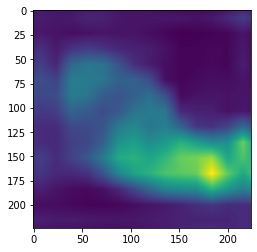

In [28]:
test = np.zeros(feature_upsampled[0].shape)
for i in range(test.shape[0]):
  for j in range(test.shape[1]):
    for k in range(len(feature_upsampled)):
      test[i,j] += feature_upsampled[k,i,j]

for i in range(test.shape[0]):
  for j in range(test.shape[1]):
    test[i,j] += np.max(test[i,j], 0)
    
plt.imshow(test)

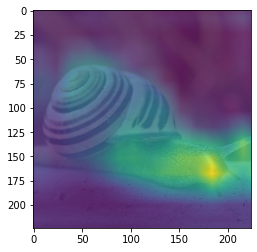

In [29]:
plt.figure()
plt.imshow(image, alpha=0.8)
plt.imshow(test, alpha = 0.8)

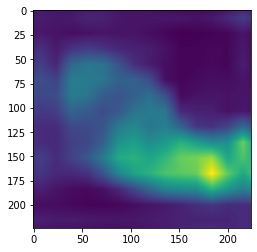

In [30]:
plt.figure()
plt.imshow(test, alpha=1)